In [16]:
import os
import pickle
import plotting
import custom_tools
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
from pathlib import Path
from scipy.stats import pearsonr
from dataset import TissueDataset
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


dataset_name = "JacksonFischer"
RAW_DATA_PATH = os.path.join("../data", f"{dataset_name}/raw")
dataset = TissueDataset(os.path.join(f"../data/{dataset_name}", "month"),  "month")

adata_exp = sc.read_h5ad(f"../data/out_data/adatafiles/JacksonFischer/JacksonFischer_JF_concatenated_explanations.h5ad")
adata_exp.obs_names_make_unique()

Seed set to 42


Target prediction: OSmonth


/home/rifaioglu/miniconda3/envs/py_gem/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [17]:
# Read json file
# exp_name = "GATV2_NegativeLogLikelihood_month_04-12-2023"
# job_id = "fombnNMthdocYhDPmAjaBQ"
exp_name = "JacksonFischer"
dataset_name = "JacksonFischer"
# job_id = "2mYvWJwUarIJkw0vvUbl3Q"
job_id = "JF"
PLT_PATH = f"../plots/analysis/{exp_name}_{job_id}"
Path(PLT_PATH).mkdir(parents=True, exist_ok=True)
device =  custom_tools.get_device()
args  = custom_tools.load_json(f"../models/{exp_name}/{job_id}.json")



# args["num_node_features"] = 33
deg = None
if "PNA" in exp_name:
    deg = custom_tools.load_pickle(f"../models/{exp_name}/{job_id}_deg.pckl")
model = custom_tools.load_model(f"{job_id}_SD", path = f"../models/{exp_name}", model_type = "SD", args = args, deg=deg, label_type = "regression", device=device)




Seed set to 42


GPU is available on this device!


In [18]:
imp_threshold = 0.75
# Get the importance of the nodes
node_importance = np.array(adata_exp.obs["importance"])
node_imp_thr = np.quantile(node_importance, imp_threshold)

importances_hard_v2 = np.array(node_importance > node_imp_thr, dtype="str")
# print("importances_hard", importances_hard)
importances_hard_v2 = pd.Series(importances_hard_v2, dtype="category")
# print(importances_hard)
adata_exp.obs["importance_hard"] = importances_hard_v2.values

In [19]:
import embeddings
emd, related_data = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, batch_size=1)
emd_cnv, related_data_cnv = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, mode="CNV", batch_size=1)

In [14]:
embedding_arr = np.array(emd[0])
pid_list, img_id_list, osmonth_lst,  clinical_type_lst, tumor_grade_lst, censor_lst= [], [], [], [], [], []
for data in related_data:
    pid_list.append(str(data.p_id[0]))
    osmonth_lst.append(data.osmonth.item())
    img_id_list.append(data.img_id[0])
    clinical_type_lst.append(data.clinical_type[0])
    tumor_grade_lst.append(str(data.tumor_grade.item()))
    censor_lst.append(data.is_censored[0].item())
embedding_arr.shape

(1114, 128)

In [ ]:
adata_emb = ad.AnnData(embedding_arr)
adata_emb.var_names = [f"emb_{i}" for i in range(embedding_arr.shape[1])]
adata_emb.obs_names = img_id_list
adata_emb.obs["img_id"] = img_id_list
adata_emb.obs["img_id"] = adata_emb.obs["img_id"].astype("category")
adata_emb.obs["osmonth"] = osmonth_lst
adata_emb.obs["p_id"] = pid_list
adata_emb.obs["clinical_type"] = clinical_type_lst
adata_emb.obs["tumor_grade"] = tumor_grade_lst
adata_emb.obs["is_censored"] = censor_lst

In [21]:
sc.tl.pca(adata_emb, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_emb)
sc.tl.leiden(adata_emb, key_added = "leiden", resolution=0.1)
sc.tl.umap(adata_emb)
# sc.pl.umap(adata, color=["osmonth", "leiden"])
upper_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.25))

adata_emb.obs["high_surv"]="0"
adata_emb.obs["low_surv"]="0"

adata_emb.obs.loc[adata_emb.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata_emb.obs.loc[adata_emb.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"



<h1>  Generation of Samples Important Regions </h1>  

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact
count=0
df_list = []
for test_graph in tqdm(dataset):
    gene_list = custom_tools.get_gene_list()
    with open(os.path.join(RAW_DATA_PATH, f'{test_graph.img_id}_{test_graph.p_id}_coordinates.pickle'), 'rb') as handle:
                coordinates_arr = pickle.load(handle)
    tmp_adata_exp = adata_exp[adata_exp.obs.img_id==test_graph.img_id,:]
    
    # Convert coordinates array to a dataframe
    coords_df = pd.DataFrame(coordinates_arr, columns=['X', 'Y'])
    # print(coords_df.shape)
    df = tmp_adata_exp.obs.copy()
    
    # Convert array to DataFrame
    new_columns = pd.DataFrame(test_graph.x, columns=gene_list)
    
    # Reset both indices to avoid index alignment issues
    df = df.reset_index(drop=True)
    new_columns = new_columns.reset_index(drop=True)

    # Concatenate without considering index values
    df = pd.concat([df, new_columns], axis=1)
    # print(df.shape)
    # add coordinates
    df = pd.concat([df, coords_df], axis=1)
    
    
    from scipy.spatial.distance import cdist

    # Assuming df has columns 'x', 'y' for region coordinates
    tumor_centroids = df[df["class"] == "Tumor"][["X", "Y"]].values
    stromal_immune_points = df[df["class"].isin(["Vessel", "Stroma", "Immune"])][["X", "Y"]].values

    # Compute minimum distance from each stromal/immune point to tumor points
    distances = cdist(stromal_immune_points, tumor_centroids, metric='euclidean')
    min_distances = distances.min(axis=1)
    # print(min_distances.shape)

    # Define a threshold (e.g., 50 pixels) to classify as peripheral
    df.loc[df["class"].isin(["Vessel", "Stroma", "Immune"]), "region_type"] = ["Peritumoural" if d < 30 else "Extratumoural" for d in min_distances]
    df.loc[df["class"].isin(["Tumor"]), "region_type"] = "Tumor"
    test_graph.region_type = df["region_type"].values
    """import seaborn as sns
    import matplotlib.pyplot as plt

    sns.boxplot(data=df, x="region_type", y="importance")
    plt.title("Importance in Intratumoural vs. Peripheral Regions")
    plt.show()"""
    
    # Subset only important regions
    important_df = df[df["importance_hard"] == "True"]
    # Compute the fraction of important regions that are Tumor
    tumor_fraction_in_important = (important_df["class"] == "Tumor").mean()
    
    marker =  "panCK"
    marker =  "c-Myc"
    tissue_region = "tumor"
    df_list.append(df)
    # print(f"Fraction of important regions that are Tumor: {tumor_fraction_in_important:.2f}")
    
    if tumor_fraction_in_important>0.7:
        node_to_score_dict = dict()
        node_to_imp_dict = dict()
        node_to_gene_dict = dict()
        node_to_region_dict = dict()
        
        for node_idx, row in df.iterrows():
            # node_idx =  int(ind.split("-")[0])
            node_to_score_dict[node_idx] = row.importance
            node_to_gene_dict[node_idx]  = row[marker]
            node_to_imp_dict[node_idx] = 1 if row.importance_hard=="True" else 0
            node_to_region_dict[node_idx] = row.region_type
        # Compute Pearson correlation
        corr, p_value = pearsonr(df["importance"], df[marker])
        
        """if corr >0.5:
            print(f"Pearson correlation: {corr}, p-value: {p_value}")
            img_id = test_graph.img_id
            print(img_id)
            plot = True
            if plot:
                plt.rcParams['figure.figsize'] = 48, 8
                fig, axs = plt.subplots(1, 4)
                
                # Define a custom pastel colormap
                colors = ["#FF9999", "#A7C7E7", "#B0E57C", "#D2B48C"]  # Pastel Red, Blue, Green, Orange
                cmap = LinearSegmentedColormap.from_list("custom_pastel", colors, N=256)
                plotting.plot_node_types_voronoi(test_graph, coordinates_arr, axs[0], node_type="ct_class", cmap =cmap,  ct_order= ["Tumor", "Stroma", "Immune", "Vessel"])
                colors = ["#FF9999", "#505050", "#D0D0D0"]  # Very dark grey, grey, light grey
                cmap = LinearSegmentedColormap.from_list("custom_grey", colors, N=256)
                plotting.plot_node_types_voronoi(test_graph, coordinates_arr, axs[1], node_type="region_type", cmap =cmap, ct_order= ["Tumor", "peripheral", "intratumoural"])
                plotting.plot_node_importances_voronoi(test_graph, coordinates_arr, node_to_score_dict, axs[2])
                plotting.plot_node_importances_voronoi(test_graph, coordinates_arr, node_to_gene_dict,  axs[3])
                
                
                # plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/{test_graph.img_id}_{tissue_region}.pdf", dpi=300)
                # plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/{test_graph.img_id}_{tissue_region}.png", dpi=300)
                plt.show()
                plt.clf()"""
        
        

    """count +=1
    if count==20:
        break"""
        
df_concat = pd.concat(df_list, ignore_index=True)         


100%|██████████| 1114/1114 [00:20<00:00, 54.81it/s]


In [25]:
df_concat
adata_emb.obs

,img_id,osmonth,p_id,clinical_type,tumor_grade,is_censored,leiden,high_surv,low_surv
222ul,222ul,121.0,113-basel,HR+HER2-,2,1,0,1,0
183lr,183lr,89.0,81-basel,TripleNeg,3,1,1,0,0
100ll,100ll,116.0,186-basel,HR+HER2-,2,1,0,1,0
358ll,358ll,200.0,250-basel,HR+HER2-,2,1,0,1,0
231lr,231lr,80.0,258-basel,HR+HER2-,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...
326lr,326lr,55.0,43-basel,HR+HER2-,2,0,1,0,0
193ul,193ul,77.0,273-basel,HR+HER2-,1,1,2,0,0
183ll,183ll,89.0,81-basel,TripleNeg,3,1,1,0,0
185ur,185ur,167.0,28-basel,HR+HER2+,2,1,0,1,0


In [26]:
# Add leiden cluster information to df_concat based on img_id
leiden_mapping = adata_emb.obs[['img_id', 'leiden']].drop_duplicates().set_index('img_id')['leiden']
df_concat['leiden'] = df_concat['img_id'].map(leiden_mapping)
df_concat['leiden'].head()


0    0
1    0
2    0
3    0
4    0
Name: leiden, dtype: category
Categories (3, object): ['0', '1', '2']

In [12]:
"""from scipy.stats import ttest_ind
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Perform the T-test
    intratumoural_importance = df_concat[df_concat["region_type"] == "intratumoural"]["importance"]
    peripheral_importance = df_concat[df_concat["region_type"] == "peripheral"]["importance"]

    t_stat, p_val = ttest_ind(intratumoural_importance, peripheral_importance)
    print(f"T-test p-value: {p_val:.4f}")

    # Define custom colors
    custom_palette = {"intratumoural": "#505050", "peripheral": "#D0D0D0"}

    # Create the boxplot
    plt.figure(figsize=(1, 3))
    ax = sns.boxplot(data=df_concat, x="region_type", y="importance", width=0.6, showfliers=False, palette=custom_palette)

    # Add significance annotation
    x1, x2 = 0, 1  # Positions of the two groups on the x-axis
    y_max = df_concat["importance"].max()  # Find max y-value for positioning
    y_max = 0.30  # Find max y-value for positioning
    y_offset = (y_max * 0.05)  # Small offset above max value

    # Draw a line for the significance annotation
    plt.plot([x1, x1, x2, x2], [y_max + y_offset, y_max + 2*y_offset, y_max + 2*y_offset, y_max + y_offset], color="black")

    # Display p-value
    p_text = f"p = {p_val:.3e}" if p_val < 0.001 else f"p = {p_val:.3f}"
    plt.text((x1 + x2) / 2, y_max + 2.5 * y_offset, p_text, ha="center", fontsize=12, fontweight="bold")

    # Formatting
    plt.title("Importance in Intratumoural vs. Peripheral Regions")
    plt.xlabel("Region Type")
    plt.ylabel("Importance")
    plt.show()
"""

'from scipy.stats import ttest_ind\n    import seaborn as sns\n    import matplotlib.pyplot as plt\n\n    # Perform the T-test\n    intratumoural_importance = df_concat[df_concat["region_type"] == "intratumoural"]["importance"]\n    peripheral_importance = df_concat[df_concat["region_type"] == "peripheral"]["importance"]\n\n    t_stat, p_val = ttest_ind(intratumoural_importance, peripheral_importance)\n    print(f"T-test p-value: {p_val:.4f}")\n\n    # Define custom colors\n    custom_palette = {"intratumoural": "#505050", "peripheral": "#D0D0D0"}\n\n    # Create the boxplot\n    plt.figure(figsize=(1, 3))\n    ax = sns.boxplot(data=df_concat, x="region_type", y="importance", width=0.6, showfliers=False, palette=custom_palette)\n\n    # Add significance annotation\n    x1, x2 = 0, 1  # Positions of the two groups on the x-axis\n    y_max = df_concat["importance"].max()  # Find max y-value for positioning\n    y_max = 0.30  # Find max y-value for positioning\n    y_offset = (y_max * 0.0

region_type
Tumor            55.155292
Peritumoural     32.029157
Extratumoural    12.815551
Name: proportion, dtype: float64


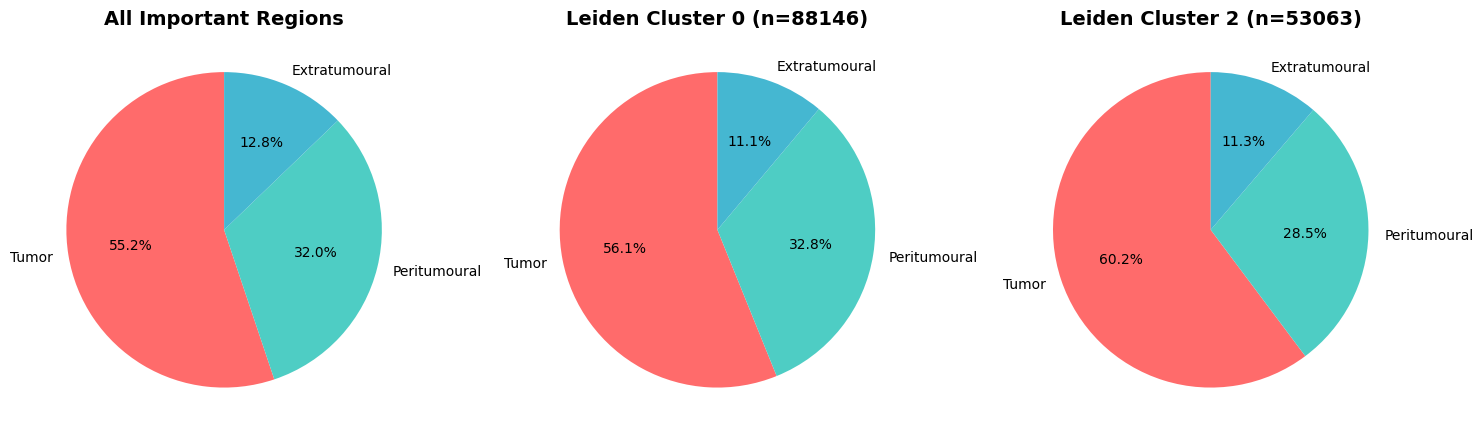

Binomial Test p-value: 1.0000


/tmp/ipykernel_1868321/2564080616.py:60: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_val = binom_test(n_intratumoural, n_intratumoural + n_peripheral, p=0.5, alternative="two-sided")


In [27]:
# Filter only important regions
df_important = df_concat[df_concat["importance_hard"] == "True"]

# Count occurrences of region types
region_counts = df_important["region_type"].value_counts(normalize=True) * 100

# Display results
print(region_counts)


import matplotlib.pyplot as plt


# Create three pie charts: overall, leiden 0, and leiden 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Define colors for region types
colors_map = {"Tumor": "#FF6B6B", "Peritumoural": "#4ECDC4", "Extratumoural": "#45B7D1"}

# Plot 1: Overall distribution (as before)
region_counts_all = df_important["region_type"].value_counts(normalize=True) * 100
colors_all = [colors_map.get(region, "#505050") for region in region_counts_all.index]
axes[0].pie(region_counts_all, labels=region_counts_all.index, autopct="%1.1f%%", colors=colors_all, startangle=90)
axes[0].set_title("All Important Regions", fontsize=14, fontweight='bold')

# Plot 2: Leiden cluster 0
df_important_leiden0 = df_important[df_important["leiden"] == "0"]
if len(df_important_leiden0) > 0:
    region_counts_leiden0 = df_important_leiden0["region_type"].value_counts(normalize=True) * 100
    colors_leiden0 = [colors_map.get(region, "#505050") for region in region_counts_leiden0.index]
    axes[1].pie(region_counts_leiden0, labels=region_counts_leiden0.index, autopct="%1.1f%%", colors=colors_leiden0, startangle=90)
    axes[1].set_title(f"Leiden Cluster 0 (n={len(df_important_leiden0)})", fontsize=14, fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'No data', ha='center', va='center')
    axes[1].set_title("Leiden Cluster 0", fontsize=14, fontweight='bold')

# Plot 3: Leiden cluster 2
df_important_leiden2 = df_important[df_important["leiden"] == "2"]
if len(df_important_leiden2) > 0:
    region_counts_leiden2 = df_important_leiden2["region_type"].value_counts(normalize=True) * 100
    colors_leiden2 = [colors_map.get(region, "#505050") for region in region_counts_leiden2.index]
    axes[2].pie(region_counts_leiden2, labels=region_counts_leiden2.index, autopct="%1.1f%%", colors=colors_leiden2, startangle=90)
    axes[2].set_title(f"Leiden Cluster 2 (n={len(df_important_leiden2)})", fontsize=14, fontweight='bold')
else:
    axes[2].text(0.5, 0.5, 'No data', ha='center', va='center')
    axes[2].set_title("Leiden Cluster 2", fontsize=14, fontweight='bold')

plt.tight_layout()
# plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/piechart_tumour_peritumoural_extratumoural.pdf", dpi=300)
# plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/piechart_tumour_peritumoural_extratumoural.png", dpi=300)
plt.show()

from scipy.stats import binom_test


n_intratumoural = (df_important["region_type"] == "intratumoural").sum()
n_peripheral = (df_important["region_type"] == "peripheral").sum()

# Perform binomial test (expected proportion = 0.5)
p_val = binom_test(n_intratumoural, n_intratumoural + n_peripheral, p=0.5, alternative="two-sided")

print(f"Binomial Test p-value: {p_val:.4f}")






In [ ]:
# Print statistics for each leiden cluster
print("=== Region Distribution Statistics ===")
print("\nOverall distribution:")
region_counts_all = df_important["region_type"].value_counts(normalize=True) * 100
print(region_counts_all)

# Leiden cluster 0
df_important_leiden0 = df_important[df_important["leiden"] == "0"]
print(f"\nLeiden Cluster 0 (n={len(df_important_leiden0)}):")
if len(df_important_leiden0) > 0:
    region_counts_leiden0 = df_important_leiden0["region_type"].value_counts(normalize=True) * 100
    print(region_counts_leiden0)
else:
    print("No data available")

# Leiden cluster 2
df_important_leiden2 = df_important[df_important["leiden"] == "2"]
print(f"\nLeiden Cluster 2 (n={len(df_important_leiden2)}):")
if len(df_important_leiden2) > 0:
    region_counts_leiden2 = df_important_leiden2["region_type"].value_counts(normalize=True) * 100
    print(region_counts_leiden2)
else:
    print("No data available")

# Statistical analysis: Chi-square test and proportion tests
if len(df_important_leiden0) > 0 and len(df_important_leiden2) > 0:
    from scipy.stats import chi2_contingency, fisher_exact
    from statsmodels.stats.proportion import proportions_ztest
    
    print("\n" + "="*60)
    print("STATISTICAL ANALYSIS: Leiden Cluster 0 vs Leiden Cluster 2")
    print("="*60)
    
    # Create contingency table
    contingency_table = pd.crosstab(
        df_important[df_important["leiden"].isin(["0", "2"])]["leiden"],
        df_important[df_important["leiden"].isin(["0", "2"])]["region_type"]
    )
    print("\nContingency Table:")
    print(contingency_table)
    
    # Chi-square test for overall independence
    chi2, p_val_chi2, dof, expected = chi2_contingency(contingency_table)
    print(f"\n--- Overall Chi-Square Test ---")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_val_chi2:.4e}")
    print(f"Degrees of freedom: {dof}")
    
    if p_val_chi2 < 0.05:
        print("✓ Significant difference in region type distribution between clusters (p < 0.05)")
    else:
        print("✗ No significant difference in region type distribution between clusters (p ≥ 0.05)")
    
    # Individual category tests (proportion tests)
    print(f"\n--- Individual Category Proportion Tests ---")
    
    region_types = df_important["region_type"].unique()
    for region in region_types:
        # Count for each cluster
        count_leiden0 = (df_important_leiden0["region_type"] == region).sum()
        count_leiden2 = (df_important_leiden2["region_type"] == region).sum()
        total_leiden0 = len(df_important_leiden0)
        total_leiden2 = len(df_important_leiden2)
        
        prop_leiden0 = count_leiden0 / total_leiden0 * 100
        prop_leiden2 = count_leiden2 / total_leiden2 * 100
        
        # Two-proportion z-test
        counts = np.array([count_leiden0, count_leiden2])
        nobs = np.array([total_leiden0, total_leiden2])
        
        z_stat, p_val_prop = proportions_ztest(counts, nobs, alternative='two-sided')
        
        print(f"\n{region}:")
        print(f"  Leiden 0: {count_leiden0}/{total_leiden0} ({prop_leiden0:.2f}%)")
        print(f"  Leiden 2: {count_leiden2}/{total_leiden2} ({prop_leiden2:.2f}%)")
        print(f"  Z-statistic: {z_stat:.4f}")
        print(f"  p-value: {p_val_prop:.4e}")
        
        if p_val_prop < 0.05:
            direction = "higher" if prop_leiden0 > prop_leiden2 else "lower"
            print(f"  ✓ Leiden 0 has significantly {direction} proportion (p < 0.05)")
        else:
            print(f"  ✗ No significant difference (p ≥ 0.05)")


=== Region Distribution Statistics ===

Overall distribution:
region_type
Tumor            55.155292
Peritumoural     32.029157
Extratumoural    12.815551
Name: proportion, dtype: float64

Leiden Cluster 0 (n=88146):
region_type
Tumor            56.127334
Peritumoural     32.751344
Extratumoural    11.121321
Name: proportion, dtype: float64

Leiden Cluster 2 (n=53063):
region_type
Tumor            60.232177
Peritumoural     28.503854
Extratumoural    11.263969
Name: proportion, dtype: float64


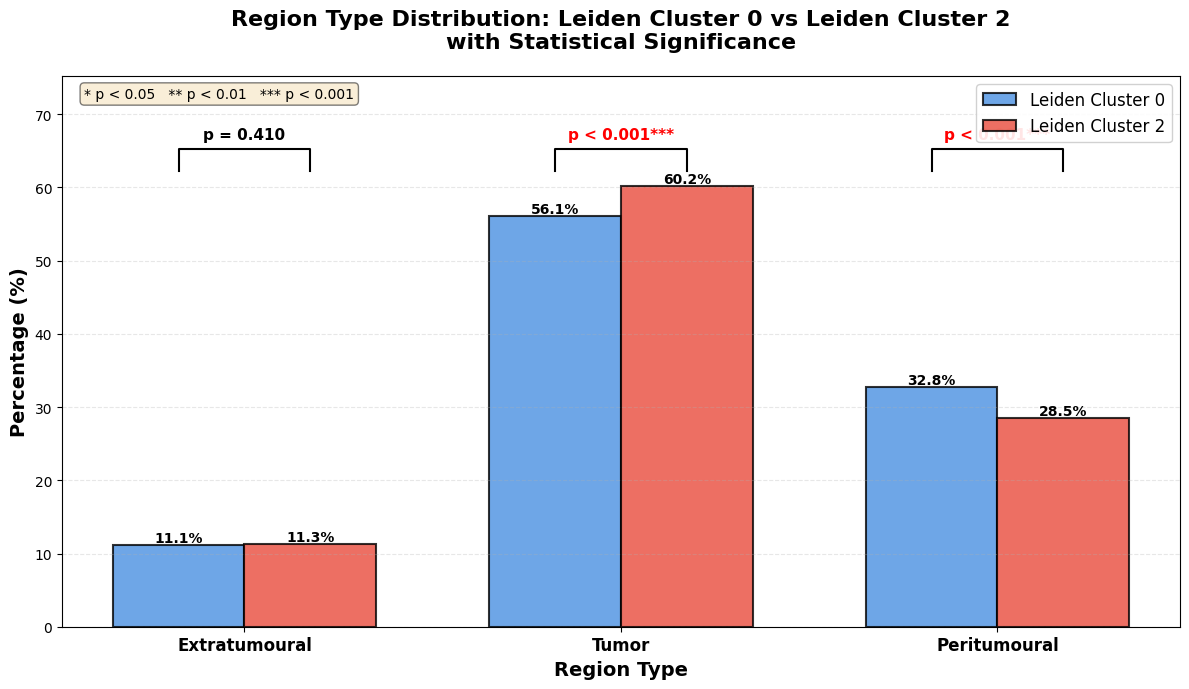


=== Summary Table ===
  Region Type Leiden 0 (%) Leiden 2 (%) Difference (%)    p-value Significant
Extratumoural        11.12        11.26          -0.14 4.0992e-01          No
        Tumor        56.13        60.23          -4.10 1.1882e-51         Yes
 Peritumoural        32.75        28.50           4.25 1.5092e-62         Yes


In [ ]:
# Visualize percentage differences with p-values
if len(df_important_leiden0) > 0 and len(df_important_leiden2) > 0:
    import matplotlib.pyplot as plt
    from statsmodels.stats.proportion import proportions_ztest
    
    # Prepare data for plotting
    region_types = df_important["region_type"].unique()
    leiden0_props = []
    leiden2_props = []
    p_values = []
    
    for region in region_types:
        count_leiden0 = (df_important_leiden0["region_type"] == region).sum()
        count_leiden2 = (df_important_leiden2["region_type"] == region).sum()
        total_leiden0 = len(df_important_leiden0)
        total_leiden2 = len(df_important_leiden2)
        
        prop_leiden0 = count_leiden0 / total_leiden0 * 100
        prop_leiden2 = count_leiden2 / total_leiden2 * 100
        
        leiden0_props.append(prop_leiden0)
        leiden2_props.append(prop_leiden2)
        
        # Calculate p-value
        counts = np.array([count_leiden0, count_leiden2])
        nobs = np.array([total_leiden0, total_leiden2])
        z_stat, p_val = proportions_ztest(counts, nobs, alternative='two-sided')
        p_values.append(p_val)
    
    # Create grouped bar plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    x = np.arange(len(region_types))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, leiden0_props, width, label='Leiden Cluster 0', 
                   color='#4A90E2', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, leiden2_props, width, label='Leiden Cluster 2', 
                   color='#E94B3C', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add percentage labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Add p-value annotations
    y_max = max(max(leiden0_props), max(leiden2_props))
    for i, (region, p_val) in enumerate(zip(region_types, p_values)):
        # Position for p-value annotation
        y_pos = y_max + 5
        
        # Format p-value
        if p_val < 0.001:
            p_text = f'p < 0.001***'
        elif p_val < 0.01:
            p_text = f'p = {p_val:.3f}**'
        elif p_val < 0.05:
            p_text = f'p = {p_val:.3f}*'
        else:
            p_text = f'p = {p_val:.3f}'
        
        # Add bracket and p-value
        bracket_height = y_pos
        ax.plot([i - width/2, i - width/2, i + width/2, i + width/2], 
               [y_max + 2, bracket_height, bracket_height, y_max + 2],
               'k-', linewidth=1.5)
        
        ax.text(i, bracket_height + 1, p_text, ha='center', va='bottom', 
               fontsize=11, fontweight='bold',
               color='red' if p_val < 0.05 else 'black')
    
    # Formatting
    ax.set_xlabel('Region Type', fontsize=14, fontweight='bold')
    ax.set_ylabel('Percentage (%)', fontsize=14, fontweight='bold')
    ax.set_title('Region Type Distribution: Leiden Cluster 0 vs Leiden Cluster 2\nwith Statistical Significance', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(region_types, fontsize=12, fontweight='bold')
    ax.legend(fontsize=12, loc='upper right', framealpha=0.9)
    ax.set_ylim(0, y_max + 15)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add note about significance levels
    ax.text(0.02, 0.98, '* p < 0.05   ** p < 0.01   *** p < 0.001', 
           transform=ax.transAxes, fontsize=10, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/leiden_cluster_comparison_barplot.pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/leiden_cluster_comparison_barplot.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary table
    print("\n=== Summary Table ===")
    summary_df = pd.DataFrame({
        'Region Type': region_types,
        'Leiden 0 (%)': [f"{p:.2f}" for p in leiden0_props],
        'Leiden 2 (%)': [f"{p:.2f}" for p in leiden2_props],
        'Difference (%)': [f"{l0-l2:.2f}" for l0, l2 in zip(leiden0_props, leiden2_props)],
        'p-value': [f"{p:.4e}" for p in p_values],
        'Significant': ['Yes' if p < 0.05 else 'No' for p in p_values]
    })
    print(summary_df.to_string(index=False))


In [ ]:
df_concat["region_type"]

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact
count=0
for test_graph in tqdm(dataset):
    gene_list = custom_tools.get_gene_list()
    with open(os.path.join(RAW_DATA_PATH, f'{test_graph.img_id}_{test_graph.p_id}_coordinates.pickle'), 'rb') as handle:
                coordinates_arr = pickle.load(handle)
    tmp_adata_exp = adata_exp[adata_exp.obs.img_id==test_graph.img_id,:]
    
    df = tmp_adata_exp.obs.copy()
    print(test_graph)
    # Convert array to DataFrame
    new_columns = pd.DataFrame(test_graph.x, columns=gene_list)
    
    # Reset both indices to avoid index alignment issues
    df = df.reset_index(drop=True)
    new_columns = new_columns.reset_index(drop=True)

    # Concatenate without considering index values
    df = pd.concat([df, new_columns], axis=1)
    
    

    # Subset only important regions
    important_df = df[df["importance_hard"] == "True"]
    # Compute the fraction of important regions that are Tumor
    tumor_fraction_in_important = (important_df["class"] == "Immune").mean()

    # print(f"Fraction of important regions that are Tumor: {tumor_fraction_in_important:.2f}")
    marker_protein = "CD3"
    if tumor_fraction_in_important>0.7:
        node_to_score_dict = dict()
        node_to_imp_dict = dict()
        node_to_gene_dict = dict()
        
        for node_idx, row in df.iterrows():
            # node_idx =  int(ind.split("-")[0])
            node_to_score_dict[node_idx] = row.importance
            node_to_gene_dict[node_idx]  = row[marker_protein]
            node_to_imp_dict[node_idx] = 1 if row.importance_hard=="True" else 0
        # Compute Pearson correlation
        corr, p_value = pearsonr(df["importance"], df[marker_protein])
        
        # if corr >0.5:
        print(f"Pearson correlation: {corr}, p-value: {p_value}")
        img_id = test_graph.img_id
        print(img_id)
        plt.rcParams['figure.figsize'] = 48, 8
        fig, axs = plt.subplots(1, 4)
        # plotting.plot_graph(test_graph, coordinates_arr, axs[0], font_size=5,  node_size=100, width=1)
        plotting.plot_node_importances_voronoi(test_graph, coordinates_arr, node_to_imp_dict,  axs[0], cmap=plt.cm.afmhot_r)
        # plotting.plot_node_importances(test_graph, coordinates_arr, node_to_score_dict,  axs[2], node_size=100, width=1)
        plotting.plot_node_importances_voronoi(test_graph, coordinates_arr, node_to_score_dict, axs[1])
        plotting.plot_node_importances_voronoi(test_graph, coordinates_arr, node_to_gene_dict, axs[2])
        plotting.plot_node_types_voronoi(test_graph, coordinates_arr, axs[3])
        plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/{test_graph.img_id}.pdf")
        plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/{test_graph.img_id}.png")
        plt.show()
        plt.clf()
        
        

    """count +=1
    if count==500:
        break"""
    

<h1> Important regions periphrael   </h1>

In [7]:
import pandas as pd

count=0
for test_graph in tqdm(dataset):
    gene_list = custom_tools.get_gene_list()
    with open(os.path.join(RAW_DATA_PATH, f'{test_graph.img_id}_{test_graph.p_id}_coordinates.pickle'), 'rb') as handle:
                coordinates_arr = pickle.load(handle)
    tmp_adata_exp = adata_exp[adata_exp.obs.img_id==test_graph.img_id,:]
    
    # Convert coordinates array to a dataframe
    coords_df = pd.DataFrame(coordinates_arr, columns=['X', 'Y'])
    df = tmp_adata_exp.obs.copy()
    
    # Convert array to DataFrame
    new_columns = pd.DataFrame(test_graph.x, columns=gene_list)
    
    # Reset both indices to avoid index alignment issues
    df = df.reset_index(drop=True)
    new_columns = new_columns.reset_index(drop=True)

    # Concatenate without considering index values
    df = pd.concat([df, new_columns], axis=1)
    # add coordinates
    df = pd.concat([df, coords_df], axis=1)
    
    from scipy.spatial.distance import cdist

    # Assuming df has columns 'x', 'y' for region coordinates
    tumor_centroids = df[df["class"] == "Tumor"][["X", "Y"]].values
    stromal_immune_points = df[df["class"].isin(["Stroma", "Immune"])][["X", "Y"]].values

    # Compute minimum distance from each stromal/immune point to tumor points
    distances = cdist(stromal_immune_points, tumor_centroids, metric='euclidean')
    min_distances = distances.min(axis=1)
    # print(min_distances.shape)

    # Define a threshold (e.g., 50 pixels) to classify as peripheral
    df.loc[df["class"].isin(["Stroma", "Immune"]), "region_type"] = ["peripheral" if d < 50 else "intratumoural" for d in min_distances]
    
    """;"""


    
    

100%|██████████| 1114/1114 [00:09<00:00, 120.54it/s]


In [ ]:
"""import matplotlib.pyplot as plt

# Define colors for different regions
colors = {
    "Tumor": "red",
    "Intratumoural": "blue",
    "Peripheral": "green"
}

# Plot tumor cells
tumor_cells = df[df["class"] == "Tumor"]
plt.scatter(tumor_cells["X"], tumor_cells["Y"], color="red", label="Tumor", alpha=0.6)

# Plot stromal/immune cells classified as peripheral or intratumoural
for region in ["intratumoural", "peripheral"]:
    subset = df[df["region_type"] == region]
    plt.scatter(subset["X"], subset["Y"], color=colors[region], label=region.capitalize(), alpha=0.6)

# Formatting
plt.xlabel("X Coordinate (µm)")
plt.ylabel("Y Coordinate (µm)")
plt.title("Spatial Distribution of Tumor and Peripheral Regions")
plt.legend()
plt.show()
from sklearn.neighbors import NearestNeighbors
import pandas as pd


# Get tumor and stromal/immune coordinates
tumor_coords = df[df["class"] == "Tumor"][["X", "Y"]].values
stromal_immune_coords = df[df["class"].isin(["Stroma", "Immune"])][["X", "Y"]].values

# Fit k-NN model on tumor cells
knn = NearestNeighbors(n_neighbors=5, metric="euclidean")  # 5 nearest neighbors
knn.fit(tumor_coords)

# Find nearest tumor neighbors for each stromal/immune cell
distances, indices = knn.kneighbors(stromal_immune_coords)

# Classify cells based on the proximity of nearest neighbors
df.loc[df["class"].isin(["Stroma", "Immune"]), "region_type"] = [
    "intratumoural" if d.mean() < 50 else "peripheral" for d in distances  # Adjust threshold as needed
]

print(df)
"""

    clinical_type img_id       p_id  tumor_grade  osmonth  importance  \
0        HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.121187   
1        HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.116591   
2        HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.154375   
3        HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.158961   
4        HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.161679   
..            ...    ...        ...          ...      ...         ...   
943      HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.148381   
944      HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.101997   
945      HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.085746   
946      HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.173569   
947      HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.108172   

    importance_hard        cell_type   class  H3K27me3  ...       pS6  \
0             False  Small elongated  Stroma  0.42